# Рынок заведений общественного питания Москвы

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

## Оглавление

1. [Изучение данных из файла](#id)
2. [Анализ данных](#ad)
3. [Общий вывод](#ov)

##  1. Изучение данных из файла <a class="anchor" id="id"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import plotly.express as px 
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
from plotly import graph_objects as go
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
register_matplotlib_converters()

In [2]:
# База по заведениям общественного питания
rest_data = pd.read_csv('/datasets/rest_data.csv')
display(rest_data.head())
rest_data.info()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [3]:
# Проверяю наличие пропусков
print('Пропуски в rest_data:', rest_data.isna().sum())
# Проверяю наличие дубликатов
print('Количество дубликатов в rest_data:', rest_data.duplicated().sum())

Пропуски в rest_data: id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64
Количество дубликатов в rest_data: 0


In [4]:
# Привожу названия в столбце object_name к нижнему регистру 
rest_data['object_name'] = rest_data['object_name'].str.lower()

In [5]:
# Проверяю кол-во сетевых заведений с одним заведением
fake_chains = (
    rest_data.query('chain == "да"').groupby('object_name').agg({'object_type': 'count'})
    .query('object_type == 1').reset_index()
)
display(fake_chains.head())
print(fake_chains['object_type'].sum())

,object_name,object_type
0,beverly hills diner,1
1,bierloga,1
2,black & white,1
3,boobo,1
4,bubbleology,1


331


In [6]:
# Заменяю значения на несетевые 
rest_data.loc[rest_data['object_name'].isin(fake_chains['object_name'].unique()), 'chain'] = 'нет'

**Вывод**

В таблице 6 колонок, типы данных - int64, object.

Количество значений в столбцах не различается. Пропусков нет, дубликатов не обнаружил, привел названия в столбце object_name к нижнему регистру для удобства группировки и т.д. 

Заменил значения сетевых объектов общественного питания с одним заведением на несетевые.  

Согласно документации к данным:

* `id` — идентификатор объекта;
* `object_name` — название объекта общественного питания;
* `chain` — сетевой ресторан;
* `object_type` — тип объекта общественного питания;
* `address` — адрес;
* `number` — количество посадочных мест.

 ##  2. Анализ данных <a class="anchor" id="ad"></a>

chain,да,нет,total,ratio
object_type,,,,
кафе,1243,4856,6099,0.20
столовая,3,2584,2587,0.00
ресторан,456,1829,2285,0.20
предприятие быстрого обслуживания,744,1179,1923,0.39
бар,19,837,856,0.02
буфет,11,574,585,0.02
кафетерий,46,352,398,0.12
закусочная,45,315,360,0.12
магазин (отдел кулинарии),70,203,273,0.26


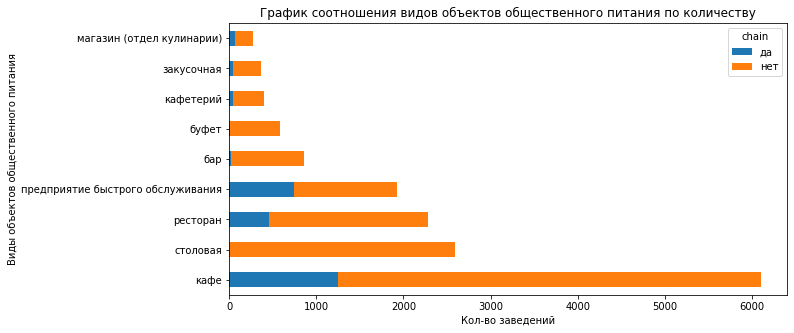

In [7]:
# Таблица соотношения видов объектов общественного питания по количеству
report = rest_data.pivot_table(index = 'object_type', columns = 'chain', values = 'id', aggfunc = 'nunique')
report['total'] = report['да'] + report['нет']
report['ratio'] = report['да'] / report['total']
report = report.sort_values(by = 'total', ascending = False)
display(report)
# График соотношения видов объектов общественного питания по количеству
report[['да', 'нет']].plot(kind = 'barh', stacked = True, figsize = (10, 5))
plt.title('График соотношения видов объектов общественного питания по количеству')
plt.xlabel('Кол-во заведений')
plt.ylabel('Виды объектов общественного питания')
plt.show()

На графике видно, что самый распространенный вид заведений - это кафе. Далее идут столовые, рестораны и предприятия быстрого обслуживания. Меньше всего в Москве магазинов(отдел кулинарии), закусочных и кафетериев. Также стоит обратить внимание, что несетевых заведений гораздо больше, чем сетевых.

Сетевое распространение характерно для кафе, ресторанов, предприятий быстрого обслуживания и магазинов (отдел кулинарии). Самый большой процент у предприятий быстрого обслуживания, почти 40%. Для заведений остальных типов доля сетевых невысокая, а сетевых столовых практически нет, их всего 3 из 2587.

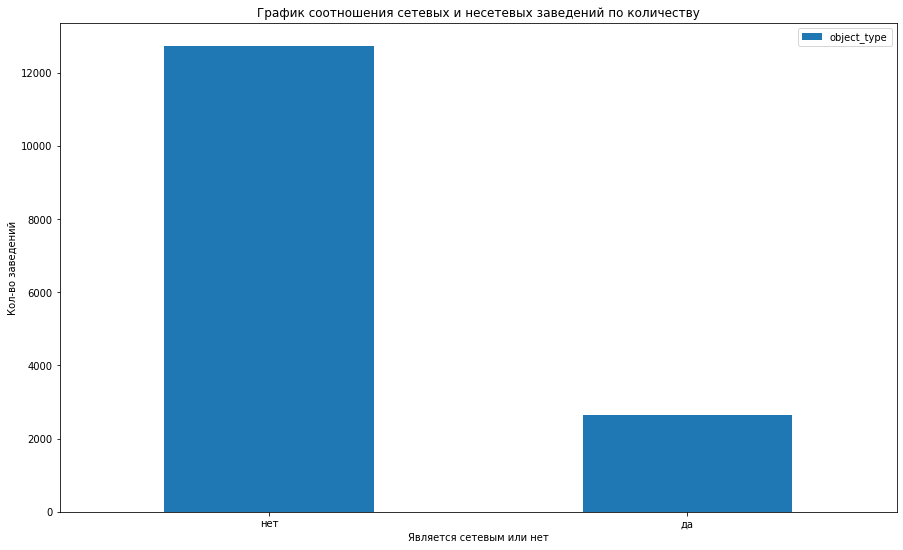

In [8]:
# График соотношения сетевых и несетевых заведений по количеству
rest_data.groupby('chain').agg({'object_type': 'count'}).sort_values(by = 'object_type', ascending = False 
                                                                      ).plot(kind="bar", figsize = (15, 9), rot = 0)
plt.title('График соотношения сетевых и несетевых заведений по количеству')
plt.xlabel('Является сетевым или нет')
plt.ylabel('Кол-во заведений')
plt.show()

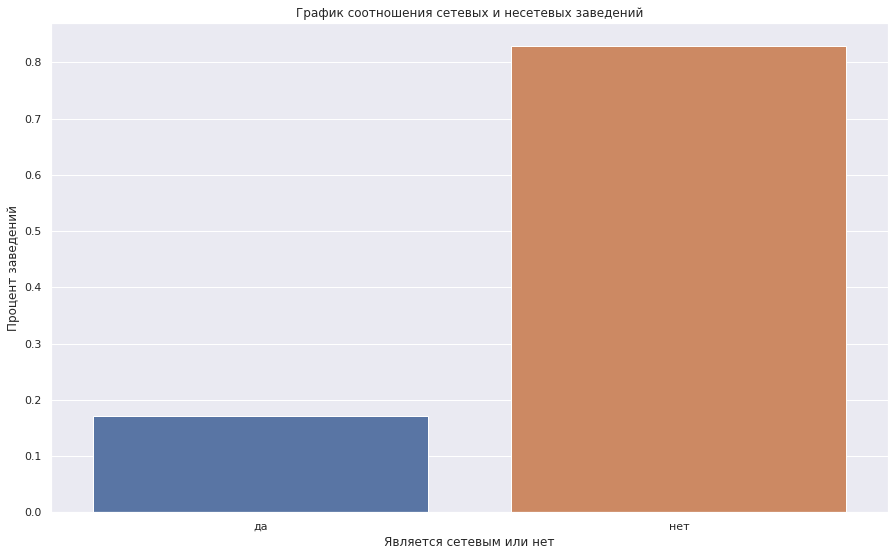

In [9]:
# График соотношения сетевых и несетевых заведений
chains_data = rest_data.groupby('chain')['id'].count().reset_index().rename(columns={'id':'counts'})
chains_data['ratio'] = chains_data['counts'] / chains_data['counts'].sum()
sns.set(rc={'figure.figsize':(15, 9)})
sns.barplot(x = 'chain', y = 'ratio', data = chains_data)
plt.title('График соотношения сетевых и несетевых заведений')
plt.xlabel('Является сетевым или нет')
plt.ylabel('Процент заведений')
plt.show()

Действительно несетевых заведений в разы больше, чем сетевых. Из всех заведений только ~16% являются сетевыми, визуализация это подтверждает. График соотношения видов объектов общественного питания по количеству показывает, что большая часть сетевых заведений - это кафе. Далее идут предприятия быстрого обслуживания и рестораны, для этих видов объектов общественного питания  характерно сетевое распространение. 

In [10]:
# База сетевых заведений
chain_yes_data = rest_data.query('chain == "да"')
chain_yes_data = chain_yes_data.groupby('object_name').agg({'id': 'count', 'number':'mean'}).rename(
                                                            columns={'id':'counts', 'number':'places'})
chain_yes_data.describe()

,counts,places
count,246.00,246.00
mean,10.72,59.39
std,22.68,49.55
min,2.00,0.00
25%,2.00,21.12
50%,4.00,44.00
75%,7.00,85.00
max,157.00,258.67


Чтобы ответить на вопрос, что характерно для сетевых заведений, нужно установить границы. Допустим, что мало заведений - меньше 5, мало посадочных мест - меньше 20.

,Число сетей,Медианное число заведений,Медианное число посадочных мест
Группа,,,
Мало заведений - Мало мест,34,2,15.10
Мало заведений - Много мест,120,3,62.75
Много заведений - Мало мест,23,13,11.50
Много заведений - Много мест,69,10,57.18


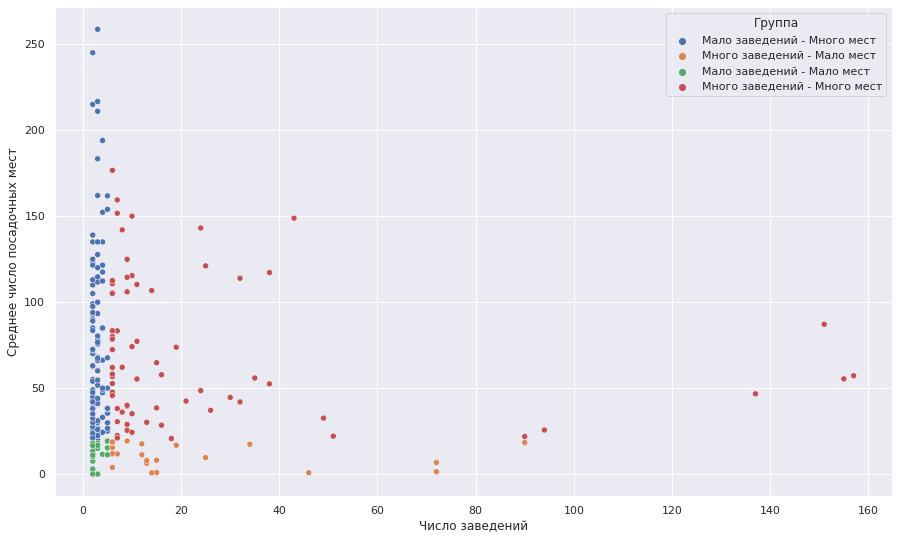

In [11]:
# Таблица и график по кол-ву заведений и мест
chain_yes_data['rest_num_group'] = 'Мало заведений' 
chain_yes_data.loc[chain_yes_data['counts'] > 5, 'rest_num_group'] = 'Много заведений' 
chain_yes_data['seat_num_group'] = 'Мало мест' 
chain_yes_data.loc[chain_yes_data['places'] > 20, 'seat_num_group'] = 'Много мест' 
chain_yes_data['Группа'] = chain_yes_data['rest_num_group'].astype(str) + ' - ' + chain_yes_data['seat_num_group'].astype(str)
sns.scatterplot(data = chain_yes_data, x = 'counts', y = 'places', hue = 'Группа')
plt.xlabel('Число заведений')
plt.ylabel('Среднее число посадочных мест')
chain_yes_data.reset_index().groupby('Группа').agg({'object_name': 'nunique', 'counts': 'median', 'places':'median'})\
                            .rename(columns={'object_name': 'Число сетей',
                                             'counts':'Медианное число заведений', 
                                             'places':'Медианное число посадочных мест'})

Из выделенных 4 групп можно сделать вывод, что для сетевых заведений характерно: мало заведений - много мест (120 сетей). Это самый распространненый вариант, далее, идет много заведений - много мест, 69 сетей.	

,number
object_type,
столовая,130.25
ресторан,96.83
буфет,51.13
бар,43.49
кафе,39.72
предприятие быстрого обслуживания,20.55
кафетерий,9.12
закусочная,7.61
магазин (отдел кулинарии),5.59


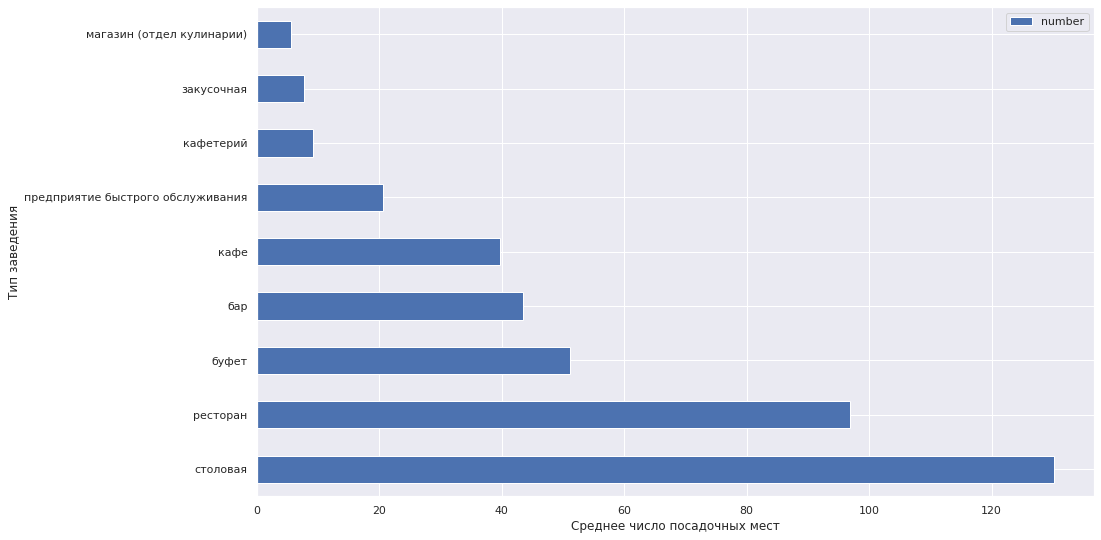

In [12]:
# Таблица и график по типу заведения и среднему кол-ву мест
type_data = (
    rest_data.groupby('object_type').agg({'number':'mean'})
    .sort_values(by = 'number', ascending = False)
)
display(type_data)
type_data.plot(kind = 'barh',stacked = True, grid = True)
plt.xlabel('Среднее число посадочных мест')
plt.ylabel('Тип заведения')
plt.show()

График показывает, что в среднем самое большое количество посадочных мест у столовых. Следом, идут рестораны и буфеты.  

In [13]:
# Выделяю в отдельный столбец информацию об улице
rest_data['street_name'] = rest_data['address'].apply(lambda x: x.split(',')[1]) 
rest_data['street_name'] = rest_data['street_name'].str.strip()
display(rest_data.head())

,id,object_name,chain,object_type,address,number,street_name
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


In [14]:
# Подгружаю таблицу с названиями улиц и районами
from io import BytesIO
import requests
spreadsheet_id = '1CPDYDGjKCb6jGoQt9KR5WOvTspK-dHS3NUrVeqsyqJs'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
streets = pd.read_csv(BytesIO(r.content))
display(streets.head())

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


,street_name,count
0,город Зеленоград,232
1,проспект Мира,204
2,Профсоюзная улица,182
3,Ленинградский проспект,171
4,Пресненская набережная,167
5,Варшавское шоссе,161
6,Ленинский проспект,147
7,поселение Сосенское,138
8,проспект Вернадского,132
9,Кутузовский проспект,114


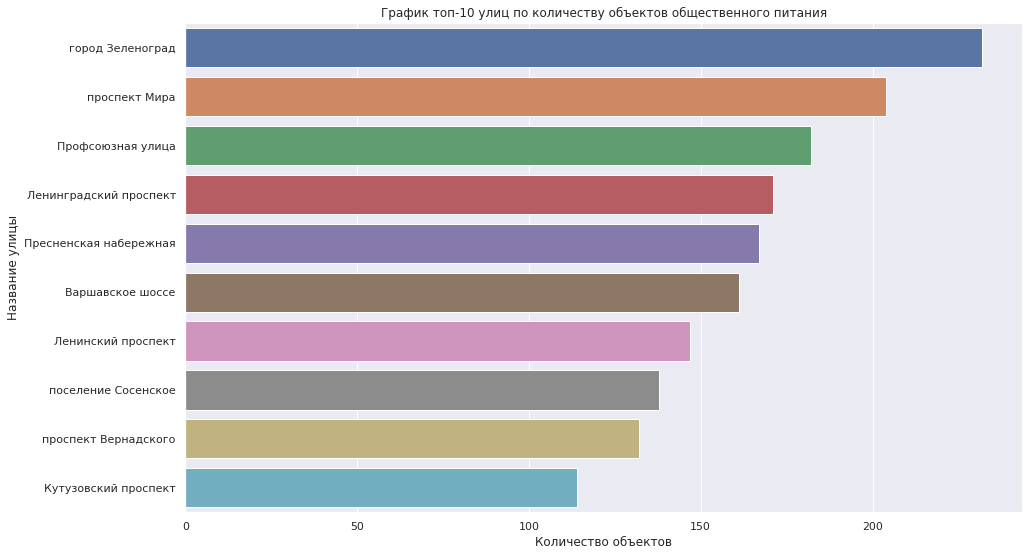

In [15]:
# Таблица и график топ-10 улиц по количеству объектов общественного питания
streets_data = (
    rest_data.groupby('street_name').agg({'id':'count'})
    .sort_values(by='id', ascending=False).reset_index()
    .rename(columns={'id':'count'})
)
top_10 = streets_data.head(10)
display(top_10)
sns.barplot(x = 'count', y = 'street_name', data = top_10)
plt.title('График топ-10 улиц по количеству объектов общественного питания')
plt.xlabel('Количество объектов')
plt.ylabel('Название улицы')
plt.show()

In [16]:
# Объединяю таблицы
streets = streets.rename(columns={'streetname':'street_name'})
district = streets_data.merge(streets, on='street_name', how='left')
district = district.drop(['count', 'areaid'], 1)
display(district.head())

,street_name,okrug,area
0,город Зеленоград,Зеленоград,Район Крюково
1,город Зеленоград,Зеленоград,Район Матушкино-Савелки
2,город Зеленоград,Зеленоград,Панфиловский район
3,проспект Мира,СВАО,Алексеевский район
4,проспект Мира,СВАО,Ярославский Район


Из полученной информации можно сделать вывод, что топ-10 улиц по количеству объектов общественного питания располагается в разных районах и в разных частях города. 

In [17]:
# Таблица улиц и районов с одним объектом общественного питания
streets_one_res = streets_data.query('count == 1').reset_index(drop=True)
district_one_res = streets_one_res.merge(streets, on='street_name', how='left')
district_one_res = district_one_res.drop('areaid', 1)
display(district_one_res.head())

,street_name,count,okrug,area
0,улица Демьяна Бедного,1,СЗАО,Район Хорошево-Мневники
1,Андреево-Забелинская улица,1,ВАО,Район Богородское
2,1-й Саратовский проезд,1,ЮВАО,Район Текстильщики
3,Андроньевская площадь,1,ЦАО,Таганский район
4,2-й Стрелецкий проезд,1,СВАО,Район Марьина роща


In [18]:
# Кол-во улиц с одним заведением в районах
district_one_res.groupby('area')['count'].count().sort_values(ascending=False).head(10)

area
Таганский район        27
Район Хамовники        26
Басманный район        25
Тверской район         20
Пресненский район      19
Район Марьина роща     18
Район Арбат            17
Мещанский район        16
Район Сокольники       15
Район Замоскворечье    14
Name: count, dtype: int64

Лидирующие позиции занимают районы Центрального административного округа Москвы, возможно это связано с тем, что там нет большого трафика машин и пешеходов, как на более крупных улицах или же с большой стоимостью аренды. Также это может быть связано с наличием большого количества исторических памятников архитектуры.

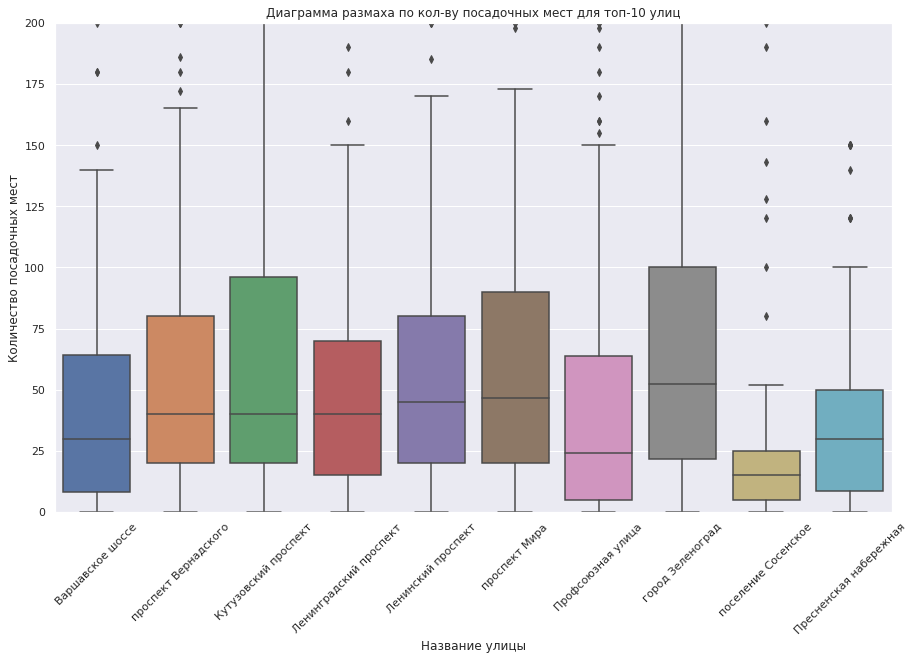

In [19]:
# Построил диаграмму размаха по кол-ву посадочных мест для топ-10 улиц
list_streets = ['город Зеленоград',
                'проспект Мира',
                'Профсоюзная улица',
                'Ленинградский проспект',
                'Пресненская набережная',
                'Варшавское шоссе',
                'Ленинский проспект',
                'поселение Сосенское',
                'проспект Вернадского',
                'Кутузовский проспект']
top_10_number = rest_data.query('street_name in @list_streets')
sns.boxplot(x = 'street_name', y = 'number', data = top_10_number)
plt.ylim(0, 200)
plt.title('Диаграмма размаха по кол-ву посадочных мест для топ-10 улиц')
plt.xlabel('Название улицы')
plt.ylabel('Количество посадочных мест')
plt.xticks(rotation=45)
plt.show()

In [20]:
top_10_number['number'].describe()

count   1,648.00
mean       57.31
std        85.58
min         0.00
25%        12.00
50%        38.00
75%        80.00
max     1,700.00
Name: number, dtype: float64

Исходя из графика, можно сделать вывод, что для улиц с большим количеством объектов общественного питания характерно небольшое количество посадочных мест. На всех улицах, кроме Зеленограда, меньше 50 посадочных мест.   

**Вывод**

1. Самый распространенные виды заведений - это кафе, столовые, рестораны и предприятия быстрого обслуживания.
2. Преобладают в основном несетевые заведения. Из всех заведений только ~16% являются сетевыми, большая часть сетевых заведений - кафе, предприятия быстрого обслуживания и рестораны.
3. Для сетевых заведений характерно: мало заведений - много мест.
4. В среднем самое большое количество посадочных мест у столовых. Следом, идут рестораны и буфеты.
5. Топ-10 улиц по количеству объектов общественного питания располагается в разных районах и в разных частях города.
6. Улицы с одним объектом общественного питания в основном располагаются в ЦАО.
7. Для улиц с большим количеством объектов общественного питания характерно небольшое количество посадочных мест.

## 3. Общий вывод <a class="anchor" id="ov"></a>

На основе полученных данных можно сделать несколько выводов:

1. Открывать заведение стоит там, где меньше конкуренции, но с хорошей проходимостью. Улицы с одним объектом общественного питания в основном располагаются в ЦАО, там много набережных и живописных мест. Стоит обратить внимание на районы: Таганский, Хамовники, Басманный, Тверской и Пресненский. Аренда в центре стоит дороже, чем на окраинах, поэтому слишком большое заведение открывать нецелесообразно. Из этого расчета, количество посадочных мест 30 - 50. Самый распространенные виды заведений - это кафе, столовые, рестораны и предприятия быстрого обслуживания. Исходя из выше сказанного, лучше выбрать формат кафе или предприятие быстрого обслуживания. Также подойдет и бар. Хотя рынок и переполнен объектами вида кафе, благодаря новизне, данный формат имеет место быть. Роботы - хорошая, инновационная идея, однако, если их функциональность не на должном уровне, то от этой идеи будут одни убытки. Если же с технической точки зрения проблем нет, то идея роботизированного заведения весьма неплоха. Если первое заведение будет прибыльное, можно задуматься о сетевом расширении.     
2. При предобработке данных в столбце object_name были обнаружены дубликаты. Из-за одинаковых названий, которые были записаны по-разному. Также в таблице были заведения с одним объектом, но причисленные к сетевым. Данные проблемы были устранены. В остальном данные были корректные и правильные. 
3. Улицы, входящие в Топ-10 по числу заведений, объединяет то, что они очень длинные и пересекают множество районов, потому на них и много объектов. Отличием является Пресненская набережная, которая тоже входит в топ-10, при сравнительно небольшом размере.

Презентация: https://disk.yandex.ru/i/OzUZBMv2bw_Kxg 